In [2]:
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re

%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 999)

In [3]:
directorio_actual = os.getcwd()
print("El directorio de trabajo actual es:", directorio_actual)


El directorio de trabajo actual es: g:\Unidades compartidas\Rocío doctorado\Proyecto NLP\Códigos


Leemos base de junio en formato csv y recreamos los tweets originales

In [4]:
datos_tweets_junio=pd.read_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_procesado.csv',  encoding='utf8')

In [5]:
datos_tweets_junio.shape

(1041585, 5)

In [6]:
datos_tweets_junio_latin=pd.read_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_procesado.csv',  encoding='latin1')

In [7]:
# # Filtrar tweets que no están cortados
datos_tweets_junio_latin = datos_tweets_junio_latin[~datos_tweets_junio_latin['full_text'].str.endswith('¦')]
# Obtener los índices de los tweets no cortados
indices_no_cortados = datos_tweets_junio_latin.index

# Filtrar otra tabla usando los índices de los tweets no cortados
datos_filtrados = datos_tweets_junio.loc[indices_no_cortados]


In [8]:
datos_filtrados.head(5)

,retweet_count,full_text,posicion,user_name,user_id
2,0,En el fondo lo que les jode es nuestra libertad #NoVotenContraLasMujeres #AbortoLegalYA,si,Luz Scarpati,2999619141
3,0,"holla! me gustaría q ayuden a esta junta d firmas para el aborto seguro y gratuito, gracias Aprueben la Ley de Aborto Seguro y Gratuito @DiputadosAR #abortolegalya #13JAbortoLegal https://t.co/aT9bKgrh9P via @ChangeorgAR",si,gigi not hadid,3668114236
6,0,Porque somos dueñas de nuestrxs cuerpas #NoVotenContraLasMujeres,si,Malena Bianca,66200186
9,0,"#NoVotenContraLasMujeres estoy tan a la mitad de tener un postura definida en este tema!!entiendo y comprendo a ambas partes,es muy triste e injusto para las dos partes!!",si,Cecilia,1005138863784976385
15,0,@MatiasRodrigTDF @LuzScarpati Que los @DiputadosAR #NoVotenContraLasMujeres #QueSeaLey,si,Elida Rechi,1475112482


In [9]:
datos_filtrados.to_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_recortados.csv', index=False)

In [10]:
df_tweets_junio=datos_filtrados
df_tweets_junio.shape

(392964, 5)

Limpiamos los textos de los tweets

In [11]:
# Descargar las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))  # Cambiar el idioma si es necesario

# Función para limpiar los tweets
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Eliminar URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Eliminar menciones de usuarios
    tweet = re.sub(r'#(\w+)', r'\1', tweet)  # Eliminar el '#' de los hashtags, dejando el texto
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Eliminar puntuación
    tweet = tweet.lower()  # Convertir a minúsculas
    tweet = re.sub(r'\brt\b', '', tweet, flags=re.IGNORECASE)  # Eliminar 'RT'
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Eliminar stopwords
    return tweet

# Limpiar los tweets en la columna 'text'
df_tweets_junio['clean_text'] = df_tweets_junio['full_text'].apply(clean_tweet)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df_tweets_junio['clean_text']

2                                                                                                 fondo jode libertad novotencontralasmujeres abortolegalya
3                holla gustaría q ayuden junta d firmas aborto seguro gratuito gracias aprueben ley aborto seguro gratuito abortolegalya 13jabortolegal via
6                                                                                                           dueñas nuestrxs cuerpas novotencontralasmujeres
9                                  novotencontralasmujeres tan mitad tener postura definida temaentiendo comprendo ambas parteses triste injusto dos partes
15                                                                                                                        novotencontralasmujeres quesealey
                                                                                 ...                                                                       
1041566                                                         

Observamos que las posiciones 'si' y 'no' están desbalanceadas

In [13]:
df_tweets_junio['posicion'].value_counts()

posicion
si    288761
no    104203
Name: count, dtype: int64

Realizamos un submuestreo de la clase mayoritaria

In [14]:
# Identificar la clase minoritaria y mayoritaria
conteo_clases = df_tweets_junio['posicion'].value_counts()
clase_minoritaria = conteo_clases.idxmin()  # Clase con menos instancias
clase_mayoritaria = conteo_clases.idxmax()  # Clase con más instancias

# Filtrar los DataFrames por clases
df_minoritaria = df_tweets_junio[df_tweets_junio['posicion'] == clase_minoritaria]
df_mayoritaria = df_tweets_junio[df_tweets_junio['posicion'] == clase_mayoritaria]

# Submuestreo de la clase mayoritaria
df_mayoritaria_submuestreada = df_mayoritaria.sample(len(df_minoritaria), random_state=42)

# Combinar los DataFrames
df_balanceado = pd.concat([df_mayoritaria_submuestreada, df_minoritaria])

# Barajar el DataFrame resultante
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar el balance final de las clases
print(df_balanceado['posicion'].value_counts())


posicion
no    104203
si    104203
Name: count, dtype: int64


Transformamos el texto en una representación numérica utilizando CountVectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Descargar stopwords en español
nltk.download('stopwords')
stop_words = list(stopwords.words('spanish'))  # Convertir el set a lista

# Vectorizar los tweets usando la lista de stopwords
vectorizer = CountVectorizer(max_df=0.99, min_df=10000, stop_words=stop_words)  # Usa la lista de stopwords
X = vectorizer.fit_transform(df_balanceado['clean_text'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from sklearn.decomposition import LatentDirichletAllocation

# Configurar el número de tópicos (ajustar según el caso)
num_topics = 2

# Entrenar el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=2, random_state=42)

In [17]:
# Mostrar las palabras más importantes por tópico
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Mostrar los temas
no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)


Tópico 1:
abortolegalya aborto noalaborto quesealey si abortosesionhistorica argentina favor mujeres abortolegal
Tópico 2:
argentinaesprovida salvemoslas2vidas vida noalabortoenargentina abortoseraley hoy abortolegal elijamoslas2vidas mujeres si


In [18]:
X_nuevo = vectorizer.transform(df_tweets_junio['clean_text'])

In [19]:
X_nuevo

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 636574 stored elements and shape (392964, 17)>

In [42]:
tabla_porcentaje = pd.crosstab(df_tweets_junio['topico'], df_tweets_junio['posicion'], normalize='columns') * 100 

# Mostrar la tabla de contingencia con porcentajes
print(tabla_porcentaje)


posicion         no         si
topico                        
0         19.946643  78.754056
1         80.053357  21.245944


In [47]:
df_tweets_junio.to_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_LDA.csv')

## Selección de muestras para evaluación anecdótica

In [3]:
datos = pd.read_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_LDA.csv')

In [8]:
conteo = datos['topico'].value_counts()
print(conteo)


topico
0    248196
1    144768
Name: count, dtype: int64


In [10]:
datos['posicion']

0         si
1         si
2         si
3         si
4         si
          ..
392959    no
392960    no
392961    no
392962    no
392963    no
Name: posicion, Length: 392964, dtype: object

In [7]:
def clean_tweet_2(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Eliminar URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Eliminar menciones de usuarios
    tweet = re.sub(r'#(\w+)', r'\1', tweet)  # Eliminar el '#' de los hashtags, dejando el texto
    #tweet = re.sub(r'#(\w+)', '', tweet)  # Eliminar el '#' de los hashtags, dejando el texto
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Eliminar puntuación
    tweet = tweet.lower()  # Convertir a minúsculas
    tweet = re.sub(r'\brt\b', '', tweet, flags=re.IGNORECASE)  # Eliminar 'RT'
    return tweet

# Limpiar los tweets en la columna 'text'
datos['clean_text_2'] = datos['full_text'].apply(clean_tweet_2)

In [9]:
datos['clean_text_2']

0                                                                                                            en el fondo lo que les jode es nuestra libertad novotencontralasmujeres abortolegalya
1                      holla me gustaría q ayuden a esta junta d firmas para el aborto seguro y gratuito gracias   aprueben la ley de aborto seguro y gratuito  abortolegalya 13jabortolegal  via 
2                                                                                                                                  porque somos dueñas de nuestrxs cuerpas novotencontralasmujeres
3                             novotencontralasmujeres estoy tan a la mitad de tener un postura definida en este temaentiendo y comprendo a ambas parteses muy triste e injusto para las dos partes
4                                                                                                                                                      que los   novotencontralasmujeres quesealey
                         

In [10]:
if datos['clean_text_2'].isnull().any():
    print("La columna 'clean_text_2' tiene celdas vacías.")
else:
    print("La columna 'clean_text_2' no tiene celdas vacías.")


La columna 'clean_text_2' no tiene celdas vacías.


In [11]:
datos.shape

(392964, 9)

In [12]:
datos= datos.drop_duplicates(['clean_text_2'])

In [13]:
datos.shape

(181886, 9)

In [14]:
unicos_user_name=datos.drop_duplicates(['user_name'])
unicos_user_name['orden'] = range(len(unicos_user_name))
muestras = []

for nombre_topico, grupo in unicos_user_name.groupby('topico'):
    n_samples = min(40, len(grupo))
    
    if n_samples > 0:  # Asegurarse de que hay usuarios disponibles
        muestra = grupo.sample(n=n_samples, random_state=42, replace=False)
        muestras.append(muestra)

# Combinar todas las muestras en un DataFrame
muestra_topicos = pd.concat(muestras).reset_index(drop=True)

# Paso 4: Seleccionar solo las columnas 'user_name', 'full_text' y 'topico'
muestra_topicos = muestra_topicos[['user_name', 'full_text', 'topico']]

# Paso 5: Unir con el DataFrame original para recuperar el orden
muestra_topicos = muestra_topicos.merge(unicos_user_name[['user_name', 'orden']], on='user_name', how='left')

# Paso 6: Ordenar por la columna 'orden' y eliminar la columna 'orden'
muestra_topicos = muestra_topicos.sort_values(by='orden').drop(columns='orden')

# Paso 7: Agregar la columna 'Clasificacion' como vacía
muestra_topicos['Clasificacion'] = ''

# Paso 8: Reordenar las columnas para que 'comunidad' esté al principio
muestra_topicos = muestra_topicos[['topico', 'user_name', 'full_text', 'Clasificacion']]

# Supongamos que ya tienes tu DataFrame llamado muestra_comunidades
# muestra_topicos = muestra_topicos.sample(frac=1)

muestra_topicos

C:\Users\rocio\AppData\Local\Temp/ipykernel_25200/454498174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unicos_user_name['orden'] = range(len(unicos_user_name))


,topico,user_name,full_text,Clasificacion
2,0,Paulina Olivera,"&lt;-—-Estudiante, mujer trabajadora de la comunicación, militante peronista y feminista. Estoy a favor del aborto legal, seguro y gratuito para todas las mujeres. #AbortoLegalYA #NoVotenContraLasMujeres",
5,0,Vanesa Carletti 💚💚,@diegobossio #ABORTOLEGALYA . Es bueno saber quien no nos representa,
62,1,Fernando Belotti,"Así viene la votación del #abortoLegal según declaraciones de los legisladores, distribuidos según su provincia. https://t.co/h28X2T7MDC",
11,0,Carrrrrla 💚,"Educación sexual para decidir, anticonceptivos para no abortar, aborto legal para no morir. Buen día. #AbortoLegalYA",
28,0,Gustavo Carrizo,Por que votas ?? #AbortoLegalYa #AbortoLegalEsVida #Las2Vidas #NoAlAborto,
18,0,Fena,"🔥 Calentando p/el miércoles,pq somos cuerpo,no es del estado,no es d la iglesia,no es d los medios,no es un objeto.Somos sujetxs capaces de decidir,somos ciudadanxs y queremos q nos reconozcan como tales.Basta d obstruir nuestra autonomía en todos los ámbitos. #abortolegalYA https://t.co/wQuRBAZu8J",
48,1,🌹Rosario Jiménez Calabrese🌹 ❤LYV❤️ IXTE💥,Angela torres y Jorgelina Aruzzi revolucionan la mesa con el pañuelo del #abortolegal 👏👏👏💚👏👏👏👏 #AlmorzandoConML,
6,0,Agus💧,"tranquila hija, la ley va a salir, no te estreses por eso *mi mamá diciendo algo que me calme* #AbortoLegalYA",
15,0,FemiNathi👿,"""Nuestros hallazgos muestran que las mujeres no eran más propensas a sufrir depresión después de un aborto en comparación con lo anterior "" #AbortoLegalYa https://t.co/BZniF34EQ2",
23,0,Marysol Antón,"&lt;------ Mujer, madre, periodista, argentina y a favor de la legalización del aborto. #NoVotenContraLasMujeres",


In [15]:
# Exportar el DataFrame a un archivo Excel con dos hojas
with pd.ExcelWriter('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/muestras_topicos.xlsx') as writer:
    muestra_topicos.to_excel(writer, sheet_name='Vanesa', index=False)
    muestra_topicos.to_excel(writer, sheet_name='Rocio', index=False)

# El archivo 'muestras_topicos.xlsx' tendrá dos hojas: 'Vanesa' y 'Rocio'

# MATRIZ DE CONFUSION EVALUACION ANECDOTICA Y TOPICOS

In [20]:
evaluacion_anecdotica_Rocio=pd.read_excel('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/muestras_topicos.xlsx'
                                    , sheet_name='Rocio')
evaluacion_anecdotica_Vanesa=pd.read_excel('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/muestras_topicos.xlsx'
                                    , sheet_name='Vanesa')

In [21]:
evaluacion_anecdotica_Rocio.columns

Index(['topico', 'user_name', 'full_text', 'Clasificacion'], dtype='object')

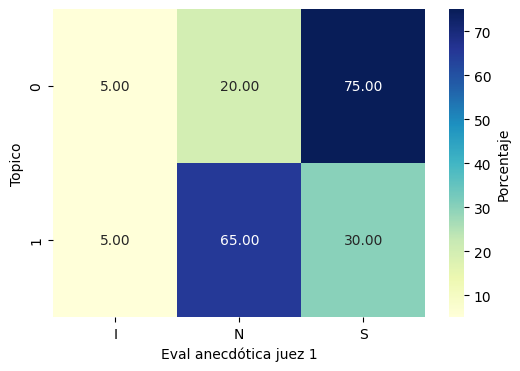

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la tabla de contingencia con los porcentajes
tabla_porcentaje = pd.crosstab(evaluacion_anecdotica_Rocio['topico'], evaluacion_anecdotica_Rocio['Clasificacion'], normalize='index') * 100

# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(tabla_porcentaje, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Porcentaje'})
plt.title("")
plt.xlabel("Eval anecdótica juez 1")
plt.ylabel("Topico")
plt.show()


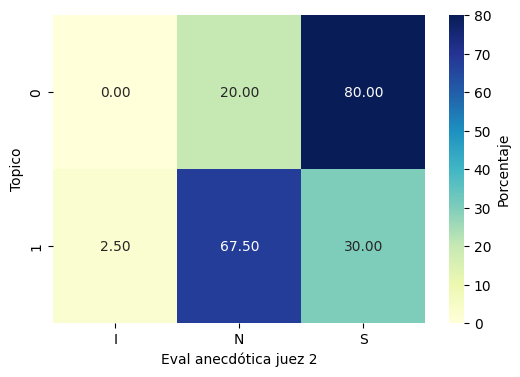

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la tabla de contingencia con los porcentajes
tabla_porcentaje = pd.crosstab(evaluacion_anecdotica_Vanesa['topico'], evaluacion_anecdotica_Vanesa['Clasificacion'], normalize='index') * 100

# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(tabla_porcentaje, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Porcentaje'})
plt.title("")
plt.xlabel("Eval anecdótica juez 2")
plt.ylabel("Topico")
plt.show()


# CONCENSO ENTRE JUECES

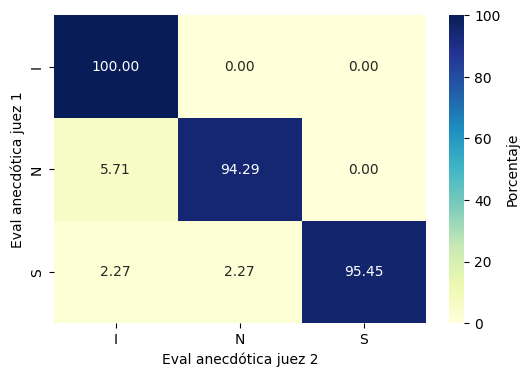

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la tabla de contingencia con los porcentajes
tabla_porcentaje = pd.crosstab(evaluacion_anecdotica_Vanesa['Clasificacion'], evaluacion_anecdotica_Rocio['Clasificacion'], normalize='index') * 100

# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(tabla_porcentaje, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Porcentaje'})
plt.title("")
plt.xlabel("Eval anecdótica juez 2")
plt.ylabel("Eval anecdótica juez 1")
plt.show()

COEFICIENte KAPPA DE COHEN

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Convertir a Series de pandas y eliminar NaN
juez1 = pd.Series(evaluacion_anecdotica_Vanesa['Clasificacion']).dropna()
juez2 = pd.Series(evaluacion_anecdotica_Rocio['Clasificacion']).dropna()

# Asegurar que ambas listas tengan la misma longitud
min_length = min(len(juez1), len(juez2))
juez1 = juez1.iloc[:min_length]
juez2 = juez2.iloc[:min_length]

# Mapear los valores categóricos a números
mapeo = {"S": 1, "N": 0, "I": 2}
juez1 = juez1.map(mapeo)
juez2 = juez2.map(mapeo)

# Calcular Kappa de Cohen
kappa = cohen_kappa_score(juez1, juez2)

print(f"Coeficiente Kappa de Cohen: {kappa:.3f}")


Coeficiente Kappa de Cohen: 0.905
